## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
## Introduction

This project seeks to understand the results of an A/B test run by an e-commerce website. The company is looking to redesign their webpage, so data was collected using both the old and the new design. 

The goal is to determine which of the two designs maximizes sales, or if a longer experiment is necessary.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import libraries.

*Note: Random seed is initially set at 42 as instructed. Changing the seed will change some values.*

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(42)

`1.` Preliminary analysis of the `ab_data.csv` data. 

a. Read in the dataset and take a look at the top few rows:

In [3]:
df = pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Number of rows in the dataset:

In [5]:
df.shape

(294478, 5)

294,478 rows.

c. The number of unique users in the dataset:

In [19]:
unique = df.drop_duplicates(subset = "user_id", keep="first")
unique.shape

(290584, 5)

290,584 unique users (approximately 4,000 repeat users)

d. The proportion of users converted:

In [20]:
converted = unique[unique.converted == 1]

prop_convert = len(converted) / len(df)
prop_convert

0.11798844056262267

11.80% converted

e. The number of times the `new_page` and `treatment` don't match:

In [21]:
no_match1 = df[((df['group'] == "treatment") == True) != ((df["landing_page"] == "new_page") == True)]
no_match.shape

no_match2

(3893, 5)

3,893 mismatches where the user either was not coded as the treatment group when they were, or they did not receive the new landing page when they should have. 

Because we do not know which condition is true, only rows where group and page match will be kept.

In [36]:
df2 = df.drop(df.query('(group == "treatment" and landing_page != "new_page") or (group != "treatment" and landing_page == "new_page") or (group == "control" and landing_page != "old_page") or (group != "control" and landing_page == "old_page")').index).reset_index()
df2.shape

(290585, 6)

In [33]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`2.` Check for missing values:

In [34]:
df2.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

There are no missing values in the dataset.

`3.` Removing repeat data.

a. Unique **user_id**s in **df2**:

In [35]:
unique_2 = df2.drop_duplicates(subset = "user_id", keep="first")
unique_2.shape

(290584, 5)

b. One **user_id** is repeated in **df2**:

In [37]:
df2[df2["user_id"].duplicated() == True]

,index,user_id,timestamp,group,landing_page,converted
2862,2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Removing the repeated **user_id**:

In [39]:
df2 = df2.drop(df2.index[2862])
df2.shape

(290584, 6)

`4.` Preliminary probability analysis.

a. Probability of an individual converting regardless of the page they receive:

In [42]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, probability that they converted:

In [43]:
control = df2[df2.group == "control"]
control['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, probability that they converted:

In [44]:
treatment = df2[df2.group == "treatment"]
treatment['converted'].mean()

0.11880806551510564

d. Probability that an individual received the new page:

In [45]:
new = df2[df2['landing_page'] == "new_page"]
new_page_prob = len(new) / len(df2)
new_page_prob

0.5000619442226688

### Initial Conclusion

**Based on this data, it does not appear that a decision can be made yet. The probabilities of users who converted when part of either group was not significantly different. If anything, those in the control group converted at a higher rate. However, more research is required before making a final decision.**

<a id='ab_test'></a>
## Part II - A/B Test

Notice that because of the time stamp associated with each event, we could run a hypothesis test continouously. However, it is difficult to know when to stop and draw a conclusion and when to look for more data.


`1.` First, we will make a decision based on the provided data. 

Assuming a Type I error rate of 5%, the null and alternative hypotheses are:

**$H_{0}$ = $p_{new}$ - $p_{old}$ $\leq$ 0**

**$H_{1}$ = $p_{new}$ - $p_{old}$ $>$ 0**

**That is, our hypothesis is that the new treatment will lead to more conversions than our old treatment, giving a positive difference.**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>


a.**Conversion rate** for $p_{new}$ under the null:

In [46]:
p_new = (df2.converted == 1).mean()
p_new

0.11959708724499628

b.**Conversion rate** for $p_{old}$ under the null: 

In [47]:
p_old = p_new
p_old

0.11959708724499628

c. $n_{new}$, the number of individuals in the treatment group:

In [54]:
n_new = df2[df2['group'] == 'treatment']
len(n_new)

145310

d. $n_{old}$, the number of individuals in the control group:

In [53]:
n_old = df2[df2['group'] == 'control']
len(n_old)

145274

e. Simulated $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null:

In [57]:
new_page_converted = np.random.choice([0,1], size=len(n_new), p=[1-p_new, p_new])
new_page_converted

array([0, 1, 0, ..., 0, 0, 1])

f. Simulated $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null:

In [58]:
old_page_converted = np.random.choice([0,1], size=len(n_old), p=[1-p_old, p_old])
old_page_converted

array([0, 0, 1, ..., 1, 0, 0])

g. $p_{new}$ - $p_{old}$ for simulated values:

In [59]:
new_page_converted.mean() - old_page_converted.mean()

-0.0015713486196687193

h. Create 10,000 $p_{new}$ - $p_{old}$ simulated values in a NumPy array called **p_diffs**

In [73]:
new_sim = np.random.binomial(len(n_new), p_new,  10000)/len(n_new)
old_sim = np.random.binomial(len(n_old), p_old,  10000)/len(n_old)
p_diffs = new_sim - old_sim
p_diffs

array([ 0.00140207, -0.00038052,  0.00041077, ..., -0.00027743,
       -0.00378069, -0.00051141])

i. Histogram of **p_diffs**. 

Text(0.5, 1.0, 'Histogram of New - Old Probability Distribution')

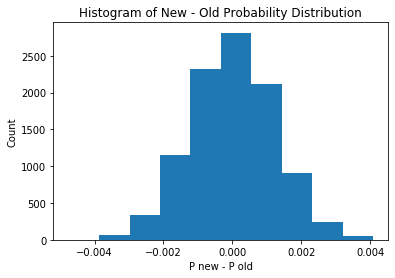

In [75]:
plt.hist(p_diffs)
plt.xlabel("P new - P old")
plt.ylabel("Count")
plt.title("Histogram of New - Old Probability Distribution")

**The shape of the histogram suggests that there is no significant difference between the two groups as the peak occurs where the difference between new and old is zero.** 

j. Proportion of the **p_diffs** greater than the actual difference observed in **ab_data.csv**:

In [77]:
actual = treatment['converted'].mean() - control['converted'].mean()
actual

-0.0015782389853555567

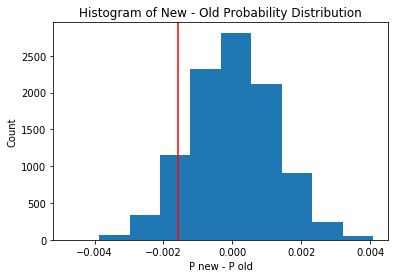

In [79]:
plt.hist(p_diffs)
plt.xlabel("P new - P old")
plt.ylabel("Count")
plt.title("Histogram of New - Old Probability Distribution")
plt.axvline(actual, color = "r")

In [80]:
p_val = (p_diffs > actual).mean()
p_val

0.9043

### Conclusion

**This *P-value* is the probability that our observed results would be true if the null hypothesis were true. That is, if there truly was no difference between the two groups, we would get the result we observed in our data set around 90% of the time. This is not a statistically significant value, meaning that there is no significant difference betwene the new and the old pages.**

l. Recalculation using the built in statsmodels.api:

In [102]:
import statsmodels.api as sm

new = df2[df2['group'] == 'treatment']
old = df2[df2['group'] == 'control']

n_new = len(df2[df2['group'] == 'treatment'])
n_old = len(df2[df2['group'] == 'control'])

convert_new = len(new[new.converted == 1])
convert_old = len(old[old.converted == 1])

m. `stats.proportions_ztest` to compute test statistic and p-value:

In [103]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old])
print(z_score, p_value)

-1.3109241984234394 0.18988337448195103


### Conclusion

**We come to the same conclusion here. The P value is still above our alpha level of 0.05, suggesting that there is no difference between the two groups.**

<a id='regression'></a>
### Part III - A regression approach

`1.` This result will also be verified using a regression model. 

a. Since each row is either a conversion or no conversion, a **logistic regression model** will be used as this predicts one of two outcomes. 

b. Creation of an **intercept** column, **new page/old page dummy columns** and an **ab_page** column that matches the **group** designation:

In [104]:
df2.head()

,index,user_id,timestamp,group,landing_page,converted
0,0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [109]:
df2['intercept'] = 1
df2[['new', 'old']] = pd.get_dummies(df2['landing_page'])
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']
df2.head()

,index,user_id,timestamp,group,landing_page,converted,intercept,ab_page,new,old
0,0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,0,1
1,1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,0,1
2,2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,1,0
3,3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,1,0
4,4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,0,1


c. Implementation of **statsmodels** to instantiate your regression model on the two columns created, fitting the model to predict whether an individual converts:  

In [113]:
from scipy import stats

model = sm.Logit(df2['converted'], df2[["intercept", 'ab_page']])
result = model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 29 Jun 2020   Pseudo R-squ.:               8.077e-06
Time:                        20:53:55   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. The p-value associated with **ab_page** is **0.190**. This is not significant and demonstrates that there is **no statistically significant difference** in conversion between the two pages. 

**This P-value is *different* from that determined in Part II because the regression model's null hypothesis is that there is no *relationship* between certain variables, but Part II's null was that there was no *difference* between the variables.**

f. **There are a range of other factors that may influence whether a customer will convert. Age may play a factor, for example, or socioeconomic background. It may also be the case that for a particular group, for example younger customers, the new page does increase conversion. These effects cannot be determined with the type of analysis completed above because all users were lumped into the same dataset. With more data, here are questions we could answer:**
<br><br>
<le>
    <li><b>Are younger users more likely to convert with the new design than older users?</b>
    <li><b>Are lower income users less likely to convert overall?</b>
    <li><b>Is there a potential third page design that may lead to more conversions? </b>
</le>
<br><br>
**However, there are some disadvantages to including more variables in the regression model. These include:**

<br>
<le>
    <li><b>Potential inclusion of outliers</b>
    <li><b>Correlation of error terms</b>
    <li><b>Non-linear response-predictor relationships </b>
</le>
<br>

g. We have user country data available, so this will be added into our regression analysis. To do so, we will merge the datasets and create new dummy variables. 

In [115]:
countries = pd.read_csv('countries.csv')

df3 = countries.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df3.head()

,country,index,timestamp,group,landing_page,converted,intercept,ab_page,new,old
user_id,,,,,,,,,,
834778,UK,143206,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1
928468,US,157345,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,1,0
822059,UK,257177,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,1,0
711597,UK,48778,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1
710616,UK,106686,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,1,0


In [117]:
countries_dummies = pd.get_dummies(df3['country'])
df_c = df3.join(countries_dummies)
df_c = df_c.drop(['country'], axis=1)
df_c.head()

,index,timestamp,group,landing_page,converted,intercept,ab_page,new,old,CA,UK,US
user_id,,,,,,,,,,,,
834778,143206,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,1,0
928468,157345,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,1,0,0,0,1
822059,257177,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,1,0,0,1,0
711597,48778,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0,1,0
710616,106686,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,1,0,0,1,0


In [126]:
model2 = sm.Logit(df_c['converted'], df_c[['intercept', 'US','UK']])

results = model2.fit()
results.summary()
                                         

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Mon, 29 Jun 2020   Pseudo R-squ.:               1.521e-05
Time:                        21:09:53   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
US             0.0408      0.027      1.518      0.129      -0.012       0.093
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
==============================================================================
"""

In [124]:
model3 = sm.Logit(df_c['converted'], df_c[['intercept','ab_page', 'US','UK']])

results = model3.fit()
results.summary()
                                         

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Mon, 29 Jun 2020   Pseudo R-squ.:               2.323e-05
Time:                        21:08:51   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
US             0.0408      0.027      1.516      0.130      -0.012       0.093
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
==============================================================================
"""

### Conclusion

**We once again come to the same conclusion. None of the countries had a P-value less than 0.05, our selected alpha value. Therefore, the country of the user also does not have a statistically significant impact on their conversion rate.** 

In [127]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0